In [1]:
!pip install scikit-learn
!pip install grad-cam

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!nvidia-smi

Sat Apr 19 21:59:30 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   2  NVIDIA A40                     Off | 00000000:8B:00.0 Off |                    0 |
|  0%   58C    P0              90W / 300W |   1140MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch

# Controleer of de GPU beschikbaar is
print("GPU beschikbaar:", torch.cuda.is_available())

# Controleer welke GPU in gebruik is
print("Huidige GPU:", torch.cuda.current_device())

# Controleer de naam van de GPU
print("GPU naam:", torch.cuda.get_device_name(torch.cuda.current_device()))


GPU beschikbaar: True
Huidige GPU: 0
GPU naam: NVIDIA A40


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import timm
from torchvision.models import densenet121
from torchvision.models import DenseNet121_Weights
from tqdm import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [5]:
# Load CSVs
df_train = pd.read_csv('./data/train_labels.csv')  # bevat kolommen 'image_path' en 'labels'
df_val = pd.read_csv('./data/val_labels.csv')
df_test = pd.read_csv('./data/test_labels.csv')

In [6]:
# Convert to string and split multi-label strings
df_train['Finding Labels'] = df_train['Finding Labels'].astype(str).str.split('|')
df_val['Finding Labels'] = df_val['Finding Labels'].astype(str).str.split('|')
df_test['Finding Labels'] = df_test['Finding Labels'].astype(str).str.split('|')

# One-hot encode labels
mlb = MultiLabelBinarizer()
label_matrix_train = mlb.fit_transform(df_train['Finding Labels'])
label_matrix_val = mlb.fit_transform(df_val['Finding Labels'])
label_matrix_test = mlb.fit_transform(df_test['Finding Labels'])

# Add the one-hot encoded labels to the Dataframe
label_df_train = pd.DataFrame(label_matrix_train, columns=mlb.classes_)
df_train = pd.concat([df_train[['Image Index']], label_df_train], axis=1)

label_df_val = pd.DataFrame(label_matrix_val, columns=mlb.classes_)
df_val = pd.concat([df_val[['Image Index']], label_df_val], axis=1)

label_df_test = pd.DataFrame(label_matrix_test, columns=mlb.classes_)
df_test = pd.concat([df_test[['Image Index']], label_df_test], axis=1)

In [7]:
df_train.to_csv('./data/train_labels_encoded.csv', index=False)
df_val.to_csv('./data/val_labels_encoded.csv', index=False)
df_test.to_csv('./data/test_labels_encoded.csv', index=False)

In [8]:
# Training set preprocessing and augmentation: Rescale 0-255 to 0-1, random horizontal flip, random zoom (range = 0.1), random rotation (range = 20)
traindata_augmentation = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.1,
    rotation_range = 20
)
    

In [9]:
# Test and val set preprocessing: only resacle from 0-255 to 0-1
val_data_augmentation = ImageDataGenerator(
    rescale = 1./255
)
test_data_augmentation = ImageDataGenerator(
    rescale = 1./255
)

In [10]:
df_train = pd.read_csv('./data/train_labels_encoded.csv')
df_val = pd.read_csv('./data/val_labels_encoded.csv')
df_test = pd.read_csv('./data/test_labels_encoded.csv')

In [11]:
#  Train Generator: will be used during the training of the model
train_generator = traindata_augmentation.flow_from_dataframe(
    dataframe= df_train,
    directory='./data/train',
    x_col='Image Index',
    y_col=mlb.classes_,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # Labels are multi hot encoded so raw is needed
    shuffle=True
)

Found 77717 validated image filenames.


In [12]:
#  Val Generator: will be used during the validation of the model
val_generator = val_data_augmentation.flow_from_dataframe(
    dataframe = df_val,
    directory = './data/val', 
    x_col='Image Index',
    y_col=mlb.classes_,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # Labels are multi hot encoded so raw is needed
    shuffle=True
)

Found 8807 validated image filenames.


In [13]:
# #  Test Generator: will be used during the testing of the model
test_generator = test_data_augmentation.flow_from_dataframe(
    dataframe = df_test,
    directory = './data/test', 
    x_col='Image Index',
    y_col=mlb.classes_,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # Labels are multi hot encoded so raw is needed
    shuffle=True
)

Found 25596 validated image filenames.


In [6]:
from torch.utils.data import Dataset, DataLoader, Subset
# from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image
import os
import pandas as pd
import random
import torch.nn as nn
import timm
import yacs.config
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

from torchvision import models

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
from collections import OrderedDict
import torch
import timm


import torch.nn.functional as F 
import torch
import torch.nn as nn
from torchvision import models
import timm
from functools import partial

import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
# Imports specifiek voor de Swin code
from timm.layers import DropPath, to_2tuple, trunc_normal_ 
from torch.utils.data import WeightedRandomSampler

In [15]:
# MODEL

In [10]:
class MLPHead(nn.Module):
    def __init__(self):
        super(MLPHead, self).__init__()
        # 3-layer MLP for every label ( 384, 48, en 48 neurons)
        self.classifier = nn.Sequential(
            nn.Linear(1536, 384),  # first lineair layer (input: 1536, output: 384)
            nn.ReLU(),  # ReLU activation
            nn.Linear(384, 48),  # second lineair layer (input: 384, output: 48)
            nn.ReLU(),  # ReLU activation
            nn.Linear(48, 48),  # Third lineair layer (input: 48, output: 48)
            nn.ReLU(),  # ReLU activation
            nn.Linear(48, 1),  # Output layer per label (1 for present label)
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x): 
        return self.classifier(x) # Classification via defined MLP

class CheXNetSwinCheX(nn.Module):
    def __init__(self, num_classes=15):
        super(CheXNetSwinCheX, self).__init__()

        # 1. CheXNet (DenseNet121 zonder classifier)
        weights = DenseNet121_Weights.IMAGENET1K_V1
        densenet = densenet121(weights=weights)
        self.chexnet = nn.Sequential(*list(densenet.features.children()))

        # Maak ALLE CheXNet parameters trainbaar
        for param in self.chexnet.parameters():
            param.requires_grad = False

        # 2. Projectie naar RGB (voor Swin input)
        self.to_rgb = nn.Conv2d(1024, 3, kernel_size=1)

        # 3. Swin-Transformer (Swin-Large, ImageNet-22k)
        self.swin = timm.create_model(
            'swin_large_patch4_window7_224',
            pretrained=True,
            num_classes=0,
            global_pool='avg'
        )

        # Maak ALLE Swin parameters trainbaar
        for param in self.swin.parameters():
            param.requires_grad = True

        # 4. MLP-heads per label
        self.heads = nn.ModuleList([MLPHead() for _ in range(num_classes)])

    def forward(self, x):
        assert x.shape[2:] == (224, 224), f"Expected 224x224 input, got {x.shape[2:]}"
        features = self.chexnet(x)
        rgb_features = self.to_rgb(features)
        swin_input = nn.functional.interpolate(rgb_features, size=(224, 224), mode='bilinear', align_corners=False)
        swin_out = self.swin(swin_input)
        outputs = [head(swin_out) for head in self.heads]
        return torch.cat(outputs, dim=1)


In [11]:
# 1. Setup
model = CheXNetSwinCheX(num_classes=15)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
# Performance lists
train_preds = [] # Predictions in trainingsset
train_labels = [] # Labels in trainingsset
val_preds = [] # Predictions in val set
val_labels = [] # Labels in valset
train_losses = [] # Losses for trainset per epoch
val_losses = [] # Losses for valset per epoch

# 2. Optimizer and scheduler
lr = 1e-4 # Learning rate 0.0001 inline with ChexViT model
epochs = 20 # 100 epochs inline with CheXViT model
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=lr/epochs) # Stochastic Gradient Descent optimizer with momentum and weight decay 
criterion = torch.nn.BCELoss() # Binary Cross-Entropy loss for multi-label classification, like used in all the papers
# Checkpoints
start_epoch = 0 
best_val_loss = float("inf")

# 3. Wrapper: Keras generator → PyTorch batch conversion
def keras_batch_to_torch(batch_x, batch_y):
    x_tensor = torch.tensor(batch_x, dtype=torch.float32).permute(0, 3, 1, 2)  # COnversion from (B, H, W, C) → (B, C, H, W) for pytorch
    y_tensor = torch.tensor(batch_y, dtype=torch.float32) # Conversion from batch_y to tensor
    return x_tensor.to(device), y_tensor.to(device) # Tensors to the device (GPU)

# 4. Training loop
for epoch in range(start_epoch, epochs): # Iteratrion through epochs
    model.train() # Put model in train mode
    train_loss = 0 # Variable to keep track of the trainloss
    train_steps = len(train_loader) # Amount of steps per epoch based on the train_generator

    pbar = tqdm(range(train_steps), desc=f"Epoch {epoch+1}/{epochs} [TRAIN]") # Progressbar for training
    for step in pbar: 
        batch_x, batch_y = next(train_loader) # Get next bath from train_generator
        inputs, targets = keras_batch_to_torch(batch_x, batch_y) # Keras batch to Pytorch tensors

        optimizer.zero_grad() # Put gradients from optimzer to zero to calculate new loss
        outputs = model(inputs) # Process the model on the input
        loss = criterion(outputs, targets) # Calculate the loss (BCEloss)
        loss.backward() # Process backpropagation
        optimizer.step() # Update the modelparameters with the optimizer

        train_loss += loss.item() # Add the loss to the total trainloss
        pbar.set_postfix({'loss': train_loss / (step + 1)}) # Show the average loss in the progress bar
    # Adding preds and real values to the list
        train_preds.append(outputs.cpu().detach().numpy())# add the predictions from the current batch
        train_labels.append(targets.cpu().detach().numpy()) # Add the true labels from the current batch


    # Validation
    model.eval() # Put the model in evaluation mode
    val_loss = 0 # Variable to keep track of the validation loss
    correct = 0 # Variable to keep track of the correct predictions
    total = 0 # Variable to keep track of the total amount of predictions

    with torch.no_grad(): # Don't calculate gradients for validation 
        for step in range(len(val_generator)): # Iterate the validation steps
            batch_x, batch_y = next(val_generator) # Get the next batch from the validation_generator
            inputs, targets = keras_batch_to_torch(batch_x, batch_y) # Convert keras batch to Pytorch tensors

            outputs = model(inputs) # Process the model on the inputs
            loss = criterion(outputs, targets) # Calculate the loss for current batch
            val_loss += loss.item() # Add the loss the the total validationloss
            # Adding preds and real values
            val_preds.append(outputs.cpu().detach().numpy()) # Add the predictions from current batch
            val_labels.append(targets.cpu().detach().numpy()) # Add the true labels from current batch

    avg_train_loss = train_loss / train_steps # Calculate average trainloss
    avg_val_loss = val_loss / len(val_generator) #Calculate average val loss
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss) # Add the average trainingloss to the list
    val_losses.append(avg_val_loss) # Add the average valiodation loss to the list

# Save every 20th epoch
if (epochs + 1) % 20 == 0 or (epochs + 1) == epochs: # only save every 20th epoch
    os.makedirs(checkpoint_dir, exist_ok=True) # Create checkpoint directory if it doesn't exist
    
    # Delete old checkpoints and keep the last two
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith("epoch_")], reverse=True) # Search to saved checkpoints
    if len(checkpoint_files) > 2:
        # Keep last 2 delete others
        os.remove(os.path.join(checkpoint_dir, checkpoint_files[-1]))

    # Save last checkpoint
    torch.save({
        'epoch': epochs + 1, # Save epoch
        'model_state_dict': model.state_dict(), # Save the parameters
        'optimizer_state_dict': optimizer.state_dict(), # Save the optimizer
        'val_loss': avg_val_loss # Save the current validationloss
    }, checkpoint_path) 
    print(f" Checkpoint saved at epoch {epochs+1}: {save_path}")


Epoch 1/20 [TRAIN]: 100%|██████████| 2429/2429 [44:19<00:00,  1.09s/it, loss=0.315]


Epoch 1: Train Loss = 0.3150 | Val Loss = 0.1916


Epoch 2/20 [TRAIN]: 100%|██████████| 2429/2429 [44:25<00:00,  1.10s/it, loss=0.198]


Epoch 2: Train Loss = 0.1981 | Val Loss = 0.1898


Epoch 3/20 [TRAIN]: 100%|██████████| 2429/2429 [44:21<00:00,  1.10s/it, loss=0.194]


Epoch 3: Train Loss = 0.1938 | Val Loss = 0.1843


Epoch 4/20 [TRAIN]: 100%|██████████| 2429/2429 [44:18<00:00,  1.09s/it, loss=0.19]


Epoch 4: Train Loss = 0.1899 | Val Loss = 0.1811


Epoch 5/20 [TRAIN]: 100%|██████████| 2429/2429 [44:22<00:00,  1.10s/it, loss=0.188]


Epoch 5: Train Loss = 0.1881 | Val Loss = 0.1801


Epoch 6/20 [TRAIN]: 100%|██████████| 2429/2429 [44:20<00:00,  1.10s/it, loss=0.187]


Epoch 6: Train Loss = 0.1870 | Val Loss = 0.1800


Epoch 7/20 [TRAIN]: 100%|██████████| 2429/2429 [44:13<00:00,  1.09s/it, loss=0.186]


Epoch 7: Train Loss = 0.1864 | Val Loss = 0.1789


Epoch 8/20 [TRAIN]: 100%|██████████| 2429/2429 [44:12<00:00,  1.09s/it, loss=0.186]


Epoch 8: Train Loss = 0.1862 | Val Loss = 0.1784


Epoch 9/20 [TRAIN]: 100%|██████████| 2429/2429 [44:10<00:00,  1.09s/it, loss=0.186]


Epoch 9: Train Loss = 0.1858 | Val Loss = 0.1782


Epoch 10/20 [TRAIN]: 100%|██████████| 2429/2429 [44:15<00:00,  1.09s/it, loss=0.186]


Epoch 10: Train Loss = 0.1856 | Val Loss = 0.1772


Epoch 11/20 [TRAIN]: 100%|██████████| 2429/2429 [44:15<00:00,  1.09s/it, loss=0.185]


Epoch 11: Train Loss = 0.1853 | Val Loss = 0.1778


Epoch 12/20 [TRAIN]: 100%|██████████| 2429/2429 [44:14<00:00,  1.09s/it, loss=0.185]


Epoch 12: Train Loss = 0.1849 | Val Loss = 0.1772


Epoch 13/20 [TRAIN]: 100%|██████████| 2429/2429 [44:13<00:00,  1.09s/it, loss=0.185]


Epoch 13: Train Loss = 0.1847 | Val Loss = 0.1774


Epoch 14/20 [TRAIN]: 100%|██████████| 2429/2429 [44:14<00:00,  1.09s/it, loss=0.184]


Epoch 14: Train Loss = 0.1844 | Val Loss = 0.1768


Epoch 15/20 [TRAIN]: 100%|██████████| 2429/2429 [44:16<00:00,  1.09s/it, loss=0.184]


Epoch 15: Train Loss = 0.1844 | Val Loss = 0.1771


Epoch 16/20 [TRAIN]: 100%|██████████| 2429/2429 [44:14<00:00,  1.09s/it, loss=0.184]


Epoch 16: Train Loss = 0.1841 | Val Loss = 0.1765


Epoch 17/20 [TRAIN]: 100%|██████████| 2429/2429 [44:15<00:00,  1.09s/it, loss=0.184]


Epoch 17: Train Loss = 0.1840 | Val Loss = 0.1761


Epoch 18/20 [TRAIN]: 100%|██████████| 2429/2429 [44:17<00:00,  1.09s/it, loss=0.184]


Epoch 18: Train Loss = 0.1836 | Val Loss = 0.1765


Epoch 19/20 [TRAIN]: 100%|██████████| 2429/2429 [44:14<00:00,  1.09s/it, loss=0.183]


Epoch 19: Train Loss = 0.1834 | Val Loss = 0.1762


Epoch 20/20 [TRAIN]: 100%|██████████| 2429/2429 [44:18<00:00,  1.09s/it, loss=0.183]


Epoch 20: Train Loss = 0.1832 | Val Loss = 0.1762


In [19]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

Class: Atelectasis - Train AUROC: 0.6785 | Val AUROC: 0.6852
Class: Cardiomegaly - Train AUROC: 0.5920 | Val AUROC: 0.6059
Class: Consolidation - Train AUROC: 0.7197 | Val AUROC: 0.7306
Class: Edema - Train AUROC: 0.7592 | Val AUROC: 0.7700
Class: Effusion - Train AUROC: 0.7711 | Val AUROC: 0.7873
Class: Emphysema - Train AUROC: 0.6776 | Val AUROC: 0.6893
Class: Fibrosis - Train AUROC: 0.5889 | Val AUROC: 0.5964
Class: Hernia - Train AUROC: 0.5864 | Val AUROC: 0.6578
Class: Infiltration - Train AUROC: 0.6142 | Val AUROC: 0.6355
Class: Mass - Train AUROC: 0.6237 | Val AUROC: 0.6285
Class: No Finding - Train AUROC: 0.6897 | Val AUROC: 0.7035
Class: Nodule - Train AUROC: 0.5644 | Val AUROC: 0.5739
Class: Pleural_Thickening - Train AUROC: 0.6359 | Val AUROC: 0.6556
Class: Pneumonia - Train AUROC: 0.6482 | Val AUROC: 0.6210
Class: Pneumothorax - Train AUROC: 0.6711 | Val AUROC: 0.7299


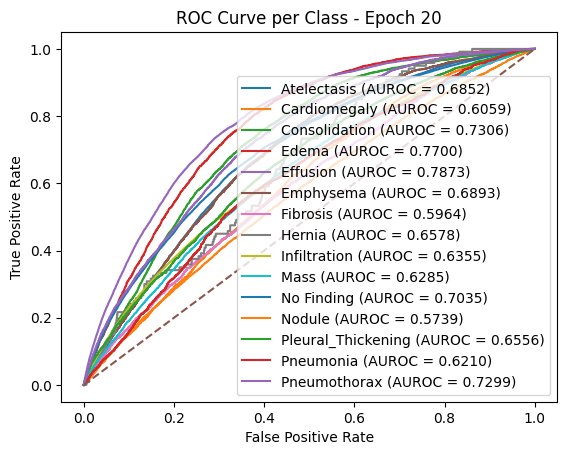

In [20]:
# Zet alles om naar numpy arrays
all_train_preds = np.concatenate(train_preds, axis=0)
all_train_labels = np.concatenate(train_labels, axis=0)
all_val_preds = np.concatenate(val_preds, axis=0)
all_val_labels = np.concatenate(val_labels, axis=0)

 # Compute AUROC per klasse
train_auroc = roc_auc_score(all_train_labels, all_train_preds, average=None, multi_class='ovr')
val_auroc = roc_auc_score(all_val_labels, all_val_preds, average= None, multi_class='ovr')

class_names = mlb.classes_  # Dit bevat de namen van de klassen
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name} - Train AUROC: {train_auroc[i]:.4f} | Val AUROC: {val_auroc[i]:.4f}")

# Plot ROC curve per klasse met class names in de label
plt.figure()
for i in range(all_val_labels.shape[1]):  # voor elke klasse
    fpr, tpr, _ = roc_curve(all_val_labels[:, i], all_val_preds[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUROC = {val_auroc[i]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve per Class - Epoch {epoch+1}')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Check aantal voorbeelden per klasse
print("Aantal voorbeelden per klasse in val_labels:")
for i, class_name in enumerate(class_names):
    count = int(np.sum(all_val_labels[:, i]))
    print(f"{class_name}: {count} voorbeelden in val set")

Aantal voorbeelden per klasse in val_labels:
Atelectasis: 15840 voorbeelden in val set
Cardiomegaly: 3220 voorbeelden in val set
Consolidation: 5780 voorbeelden in val set
Edema: 3060 voorbeelden in val set
Effusion: 16820 voorbeelden in val set
Emphysema: 2760 voorbeelden in val set
Fibrosis: 2280 voorbeelden in val set
Hernia: 120 voorbeelden in val set
Infiltration: 28360 voorbeelden in val set
Mass: 6980 voorbeelden in val set
No Finding: 105320 voorbeelden in val set
Nodule: 9100 voorbeelden in val set
Pleural_Thickening: 4040 voorbeelden in val set
Pneumonia: 1820 voorbeelden in val set
Pneumothorax: 4920 voorbeelden in val set


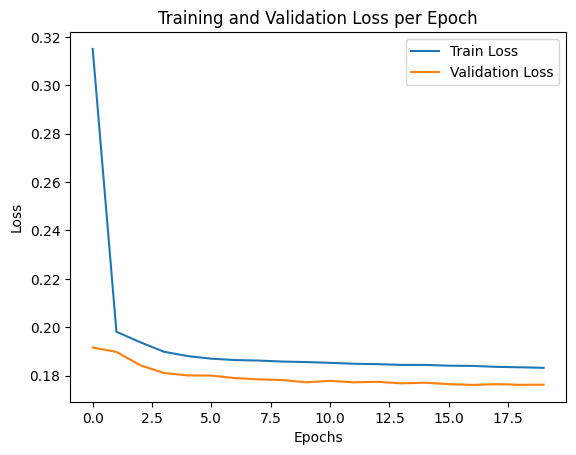

In [22]:
# Plotten van de verliesgrafiek
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [23]:
!conda env export > environment.yml